In [ ]:
import json
import pandas as pd
from pprint import pprint
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import keras
import spotipy
import spotipy.oauth2
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from scipy.sparse import coo_matrix

fileDir = os.path.dirname(os.path.realpath('__file__'))

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import

**Major To-Dos**:
- Need genres for validation
- Need lyrics for additional models
- Audio data would be a nice to have for additional models
- Other to-dos for generalizing methods / improving usability of code included below
- Try building factorization machine model
- Comparison of error on various models tried below
- **Replace track frame with URI frame given non-unique names**

**Section 1. The below loads in the datasets. The explode and unpack functions are used to generate a matrix with a line for each song play, with a playlist ID to indicate which playlist it originally came from.**

In [7]:
n_playlists = 1999
playlists_list = list()
lower_bound = 0
upper_bound = 999
step = 1000

while (upper_bound <= n_playlists):
    slice_name = 'data\mpd.slice.' + str(lower_bound) + '-' + str(upper_bound) + '.json'
    test_string = os.path.join(fileDir, slice_name)
    with open(test_string) as json_data:
        d = json.load(json_data)
        json_data.close()
        playlists_list.append(d['playlists'])
    lower_bound += step
    upper_bound += step
    
flatten = lambda l: [item for sublist in l for item in sublist]
playlists_list = flatten(playlists_list)

In [8]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)

    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]
    
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

In [9]:
temp_frame = pd.DataFrame(playlists_list)
temp_frame.tracks[0]

lst_col = 'tracks'
exploded_frame = explode(temp_frame, ['tracks'], fill_value='')
playlists_frame = unpack(exploded_frame,'tracks','')
playlists_frame.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,track_uri
0,false,NaN,11532414,1493424000,Throwbacks,47,37,6,1,52,0,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,226863,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,false,NaN,11532414,1493424000,Throwbacks,47,37,6,1,52,0,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,198800,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,false,NaN,11532414,1493424000,Throwbacks,47,37,6,1,52,0,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,235933,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,false,NaN,11532414,1493424000,Throwbacks,47,37,6,1,52,0,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,267266,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,false,NaN,11532414,1493424000,Throwbacks,47,37,6,1,52,0,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,227600,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H


**Section 2. The cell below generates a matrix of P playlists x N songs (tracks_frame), with a 1 whenever a song is present in a playlist. This is the starting format to use for a number of the recommendation system techniques.**

In [ ]:
# Create necessary starting matrix dimensions for matrix factorization
# To do: update all references to be based on track ID rather than track name
playlists_frame.drop_duplicates(['track_name','pid'],keep= 'last',inplace=True)
tracks_frame = playlists_frame.pivot_table(values = 'pos',index = 'pid', 
                                           columns ='track_name',aggfunc=lambda x:len(x.unique())).fillna(0)

In [160]:
unique_tracks = playlists_frame.drop_duplicates(subset='track_uri')

**Section 3. The cells below perform matrix factorization and test it. Matrix factorization attempts to find the "k" dimensional matrix that best approximates user's actual preferences. There is no interpretability of the resulting values, but it has strong predictive power.**

In [22]:
# Matrix factorization operations: ref https://beckernick.github.io/matrix-factorization-recommender/
U, sigma, Vt = svds(tracks_frame, k = 50)
sigma = np.diag(sigma)
first_product = np.dot(U,sigma)
all_predicted = np.dot(first_product,Vt)
pred_df = pd.DataFrame(all_predicted,columns=tracks_frame.columns)
pred_df.head()

track_name,"""*!*!"" What U Heard","""40"" - Remastered 2008","""45""","""A Lovely Night""","""A Lovely Night"" (Reprise)","""C"" Is For Cookie - Introduction","""Can't Repeat The Past?""","""Do I Love You Because You're Beautiful""","""Esh 'Dani, Alash Mshit""","""Gatsby Believed In The Green Light""",...,양화대교 (Yanghwa Brdg),오늘 헤어졌어요,왜 (Keep Your Head Down) [Rearranged],왜 이러니,우주보다 좋아해 (I Love You More Than Universe),으르렁 Growl,전야 前夜 The Eve,주문 Mirotic,중독 Overdose,"헤어지지 못하는 여자, 떠나가지 못하는 남자 Can't Breakup Girl, Can't Breakaway Boy (feat. 정인 Jung In)"
0,-0.001311,0.000029,0.000731,-0.000045,-0.000045,-0.001146,-0.000216,-0.000045,-4.344472e-19,-0.000216,...,-0.000304,0.000183,0.000183,0.000183,0.000183,-0.000802,-0.000161,0.000183,-0.000538,0.000183
1,-0.000545,0.000004,-0.000293,0.006850,0.006850,0.000055,-0.000051,0.006850,-3.026727e-19,-0.000051,...,-0.000039,-0.000043,-0.000043,-0.000043,-0.000043,-0.000072,0.000007,-0.000043,-0.000034,-0.000043
2,0.001203,0.000025,0.000073,0.000101,0.000101,0.000299,0.000032,0.000101,-1.574184e-19,0.000032,...,0.000259,0.000055,0.000055,0.000055,0.000055,0.000251,0.000219,0.000055,0.000539,0.000055
3,0.000810,-0.000027,0.000374,-0.000289,-0.000289,0.000387,0.000028,-0.000289,-2.790878e-19,0.000028,...,0.000248,0.000047,0.000047,0.000047,0.000047,0.000171,0.000150,0.000047,0.000374,0.000047
4,-0.000439,0.000017,-0.000350,0.000642,0.000642,-0.000193,-0.000059,0.000642,1.193113e-19,-0.000059,...,0.000232,0.000036,0.000036,0.000036,0.000036,-0.000021,0.000060,0.000036,-0.000270,0.000036


In [23]:
# RMSE Calculation
np.sqrt((np.power(tracks_frame - all_predicted,2)).values.sum()/(len(all_predicted.ravel())))

# To do - separate into training and test set, 
# and calculate RMSE based on different values of k, so we can find the optimal model hyperparameters

# To do - need to compare to trivial baseline of just predicting 0s all the time, since so many songs never appear in a playlist

0.03393039861888059

In [24]:
# Test matrix factorization predictions
def predict_mf(pid,pred_df,tracks_frame,num_recommendations=10):
    sorted_predictions = pred_df.iloc[pid,:].sort_values(ascending=False)
    print("Previous Picks:",tracks_frame.iloc[pid,:][tracks_frame.iloc[pid,:] == 1].index)
    print("Recommended Songs:",sorted_predictions[0:num_recommendations].index)

# Sample Predictions
#predict_mf(52,pred_df,tracks_frame) #Christmas songs
#predict_mf(250,pred_df,tracks_frame)#slow jams
predict_mf(350,pred_df,tracks_frame) #Spanish songs

Previous Picks: Index(['0 Sentimientos (Remix) [feat. Noriel, Darkiel, Lyan, Messiah & Baby Rasta]',
       'Acércate', 'Ahora Dice', 'Ahora Me Llama', 'Ahora Me Llama - Remix',
       'Ahora Que Te Vas (feat. Cosculluela)', 'Amigos y Enemigos',
       'Amigos y Enemigos - Remix', 'Ay Mami (feat. Bryant Myers)',
       'Bebe (feat. Anuel AA)', 'Bella y Sensual', 'Bonita',
       'Bonita (Down 4 Me Remix) [feat. Kevin Roldan]', 'Báilame - Remix',
       'Como Antes', 'Corazon De Seda (feat. Ozuna)', 'Cuatro Babys',
       'Desobediente (feat. Alexis Y Fido)', 'Desperte Sin Ti', 'Diabla',
       'Dile Que Tu Me Quieres',
       'Diles (feat. Arcangel, Nengo Flow, Dj Luian & Mambo Kings)',
       'Doble Personalidad', 'El Amante',
       'El Dinero No Lo Es Todo (feat. Ozuna)', 'El Farsante',
       'En La Intimidad', 'En Que País', 'Explícale', 'Fanática Sensual',
       'Felices los 4', 'Guaya', 'Hablame Claro', 'Hola Beba',
       'La Oportunidad - Remix', 'Lento', 'Lunes-Viernes', 'Ma

**Section 4. This is an implementation of what is sometimes called memory-based song-song CF. This is a simple approach that looks at songs that appear in similar playlists to a specific song. There is no attempt to identify any hidden causes or factors that might have resulted in these preferences.**

In [170]:
# Generates songs most similar to a specific song based on Pearson coefficient
myboo_ratings = tracks_frame['My Boo']
remindmeof_myboo = tracks_frame.corrwith(myboo_ratings)
corr_boo = pd.DataFrame(remindmeof_myboo,columns=['pearsonR'])
corr_boo.dropna(inplace=True)
corr_boo.sort_values('pearsonR',ascending=False).head()

# To do - memory-based user-user CF. Take songs from playlists that are similar to our playlist.
# To do - generalize into a function that will generate a set number of predictions based on an existing playlist of multiple songs.

,pearsonR
track_name,
My Boo,1.000000
Suffocate,0.557474
I Don't Wanna Know (feat. Enya & P. Diddy) - 2016 Remastered,0.508208
Let Me Hold You,0.469867
Differences,0.448663


**Section 5. This is an implementation of a k nearest neighbors approach based on songs. The model finds the songs most similar to each other.**

In [26]:
tracks_transpose = tracks_frame.transpose()
model_knn = NearestNeighbors(metric = 'cosine',algorithm = 'brute')
model_knn.fit(tracks_transpose)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [30]:
query_index = np.random.choice(tracks_transpose.shape[0])
distances, indices = model_knn.kneighbors(tracks_transpose.iloc[query_index,:].values.reshape(1,-1),n_neighbors=10)

for i in range(0,len(distances.flatten())):
    if i == 0:
        print("Original Track:",tracks_transpose.index[query_index])
    else:
        print("Nearest Neighbor Number" + str(i) + ": " + str(tracks_transpose.index[indices.flatten()[i]]) + \
              " with distance: " + str(distances.flatten()[i]))
        
# To Do: Implement knearest neighbors based on playlists, and then suggest songs from the neighbor playlists.
# To Do: Generalize into a function that takes a playlist as an input, then suggests songs based on songs in that playlist

Original Track: Fake ID (feat. Gretchen Wilson)
Nearest Neighbor Number1: Save A Horse (Ride A Cowboy) with distance: 0.434314575050762
Nearest Neighbor Number2: You Sound Good to Me with distance: 0.5527864045000421
Nearest Neighbor Number3: Drink Drank Drunk (feat. Big & Rich and Big Smo) with distance: 0.5527864045000421
Nearest Neighbor Number4: Redneck Games - with Alan Jackson with distance: 0.5527864045000421
Nearest Neighbor Number5: Ride On, Ride Out - feat. DMC with distance: 0.5527864045000421
Nearest Neighbor Number6: I Ain't In Checotah Anymore with distance: 0.5527864045000421
Nearest Neighbor Number7: Cut Me Some Slack with distance: 0.5527864045000421
Nearest Neighbor Number8: Lie a Little Better with distance: 0.5527864045000421
Nearest Neighbor Number9: Take My Drunk Ass Home - Demo with distance: 0.5527864045000421


**Section 6. This is an implementation of a neural network based approach to recommendation. The approach has many constraints - if we train it on the full dataset, it will always predict a 0. Instead, we took a limited approach and filtered for the most popular songs (at least 30) and playlists that contained at least 30 songs after the filter.**

In [152]:
from keras.layers import Input, Embedding, Flatten, Dropout, Dense, Dot
from keras import Model
from keras import optimizers

In [451]:
# To do: try same model with same filters, but on dataset of more playlists imported. 
# The filter below is to screen for songs that occur frequently, since songs that don't occur infrequently confuse the net.
# Try other activation functions

filter_data = tracks_frame.loc[:,tracks_frame.sum() > 30]
filter_data = filter_data[filter_data.sum(axis = 1) > 30]

allcombos_frame = filter_data.stack()
x_train = allcombos_frame.index.to_frame()

item_id = x_train.iloc[:,1].astype('category').cat.codes.values
user_id = x_train.iloc[:,0].astype('category').cat.codes.values

y_train = np.asarray(allcombos_frame)

n_song, n_user = len(x_train.iloc[:,1].unique()), len(x_train.iloc[:,0].unique())
n_latent_factors_song = 15
n_latent_factors_user = 15

song_input = Input(shape=[1])
song_embedding = Embedding(n_song + 1, n_latent_factors_song)(song_input)
song_vec = Flatten()(song_embedding)

user_input = Input(shape=[1])
user_embedding = Embedding(n_user + 1, n_latent_factors_user)(user_input)
user_vec = Flatten()(user_embedding)

dot = Dot(axes=1)([song_vec, user_vec])
dense_2 = Dense(100,activation='sigmoid')(dot)
dense_3 = Dense(50,activation='sigmoid')(dense_2)
dense_4 = Dense(25,activation='sigmoid')(dense_3)

result = Dense(1, activation='linear')(dense_4)
adam = optimizers.Adam()
model = Model([song_input,user_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 1, 15)        5160        input_61[0][0]                   
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 1, 15)        1260        input_62[0][0]                   
__________________________________________________________________________________________________
flatten_53

In [452]:
history = model.fit([item_id,user_id], y_train, epochs=30, verbose=1)
model.save('model.h5')

Epoch 1/30
28469/28469 [==============================] - 3s 112us/step - loss: 0.1273
Epoch 2/30
28469/28469 [==============================] - 1s 46us/step - loss: 0.1254
Epoch 3/30
28469/28469 [==============================] - 2s 54us/step - loss: 0.1243
Epoch 4/30
28469/28469 [==============================] - 1s 46us/step - loss: 0.1236
Epoch 5/30
28469/28469 [==============================] - 2s 55us/step - loss: 0.1227
Epoch 6/30
28469/28469 [==============================] - 2s 55us/step - loss: 0.1228
Epoch 7/30
28469/28469 [==============================] - 2s 54us/step - loss: 0.1222
Epoch 8/30
28469/28469 [==============================] - 2s 57us/step - loss: 0.1216
Epoch 9/30
28469/28469 [==============================] - 2s 67us/step - loss: 0.1211
Epoch 10/30
28469/28469 [==============================] - 2s 61us/step - loss: 0.1162
Epoch 11/30
28469/28469 [==============================] - 2s 64us/step - loss: 0.1101
Epoch 12/30
28469/28469 [==========================

In [453]:
yhat = model.predict([item_id,user_id])
yhat = pd.DataFrame(yhat)
yhat.columns = ['Yes']
yhat['item_id'] = item_id
yhat['user_id'] = user_id

In [478]:
#nn predict
rand_id = 43
predictions = yhat[user_id == rand_id]

y_actuals = pd.DataFrame(y_train)
y_actuals.columns=['Yes']
y_actuals['item_id'] = item_id
y_actuals['user_id'] = user_id
actuals = y_actuals[user_id == rand_id]

delta = predictions['Yes'] - actuals['Yes']
predictions['delta'] = delta
predictions = predictions.sort_values(ascending=False,by='delta')
indices_one = predictions.item_id[predictions.delta >= 0.1].values
pred_tracks = np.asarray([x_train.track_name[[index]][0] for index in indices_one])

actuals_yes = actuals[actuals.Yes == 1]
indices_two = actuals_yes.item_id.values
actual_tracks = np.asarray([x_train.track_name[[index]][0] for index in indices_two])

print("Predicted Tracks:",pred_tracks)
print("Previous Tracks:",actual_tracks)

Predicted Tracks: ['Bad and Boujee (feat. Lil Uzi Vert)' 'goosebumps'
 'Drowning (feat. Kodak Black)']
Previous Tracks: ['1-800-273-8255' 'Best I Ever Had' 'Bodak Yellow' 'Bounce Back'
 'Butterfly Effect' 'Caroline' 'Congratulations' 'DNA.' "Don't" 'HUMBLE.'
 'HeadBand (feat. 2 Chainz)' "I Don't Fuck With You" "I'm the One"
 'Jordan Belfort' 'LOVE. FEAT. ZACARI.' 'Magnolia' 'Mask Off' 'Mercy'
 'No Flockin' 'Passionfruit' 'Rake It Up' 'Redbone'
 'Slippery (feat. Gucci Mane)' 'The Motto' 'V. 3005' 'Wild Thoughts'
 'X (feat. Future)' 'XO TOUR Llif3' 'iSpy (feat. Lil Yachty)'
 'pick up the phone' 'rockstar']


C:\Users\asage\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


**Section 7. The below section utilizes a content-based recommendation approach and pulls pre-existing feature data from Spotify to generate a matrix of features. The first recommender presented below then utilizes a Pearson correlation distance to make recommendations. The recommendations are more novel than with the other systems, since it's based on underlying musical features of the songs.**

In [4]:
client_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id='8fb83172bc344baa8ca0e8b72753332e',
                                                                    client_secret='868717ae831746e39797ca2fd016e533')
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [37]:
uri_frame = playlists_frame.pivot_table(values = 'pos',index = 'pid', 
                                           columns ='track_uri',aggfunc=lambda x:len(x.unique())).fillna(0)
unique_uris = pd.DataFrame(uri_frame.columns)
unique_uris['features'] = np.zeros(len(unique_uris))

In [84]:
def get_features(start_i,end_i): #in-place function to get features in piecemeal given load-time
    unique_uris.iloc[start_i:end_i,1] = spotify.audio_features(unique_uris.iloc[start_i:end_i,0])

c = 0
while (c < 57500):
    get_features(c,c+100)
    c += 100
get_features(57500,57575)

In [94]:
unique_uris = unpack(unique_uris,'features','')
unique_uris.to_csv('trackfeatures.csv')

In [249]:
features_df = unique_uris.drop(['analysis_url','id','time_signature','track_href','type','uri','mode','key','duration_ms','instrumentalness'],axis=1)
features_df.index = features_df.track_uri
features_df.drop(['track_uri'],axis=1,inplace=True)
# potentially add back mode and key later as dummies

# Scale data to between 0 and 1
x = features_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
temp_df = pd.DataFrame(x_scaled)
temp_df.index = features_df.index
temp_df.columns = features_df.columns
features_df = temp_df

In [250]:
rand_track = features_df.iloc[20] # random track selection
corr_with_rand = features_df.corrwith(rand_track,axis=1)
corr_with_rand = pd.DataFrame(corr_with_rand,columns=['pearsonR'])
corr_with_rand.dropna(inplace=True)
corr_with_rand = corr_with_rand.sort_values('pearsonR',ascending=False)
corr_with_rand = corr_with_rand[0:10]
tracks_join = pd.merge(corr_with_rand,unique_tracks, how='left', left_on=corr_with_rand.index, right_on='track_uri')
print("Original Track:",tracks_join.track_name[0])
print("Recommended Tracks:",tracks_join.track_name[1:])

Original Track: Live For
Recommended Tracks: 1                  BTFU (Mommy Issues)
2                             Brothers
3                 Braille (feat. Lori)
4                                Dress
5    The Calm - Album Version (Edited)
6                            Last Time
7            Drip, Drop, Drippity Drop
8             Didn't I See This Movie?
9                              Borders
Name: track_name, dtype: object


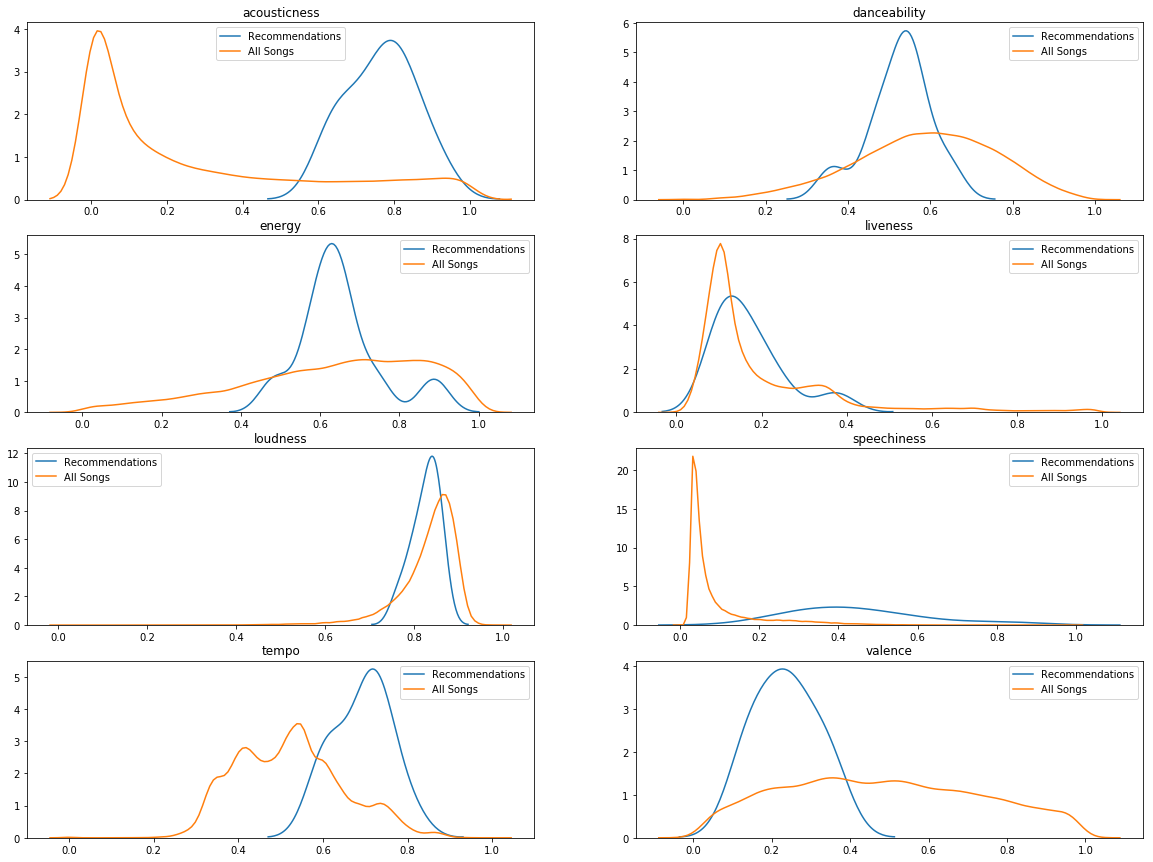

In [251]:
# Check distribution of features compared to overall sample to make sure we are actually recommending similar songs compared to the average
rec_feat =  pd.merge(corr_with_rand,features_df, how='left', left_on=corr_with_rand.index, right_on=features_df.index)

rec_feat.columns
fig, axs = plt.subplots(4,2, figsize=(20,15))
for i in range(0,len(features_df.iloc[0,:])):
    sns.kdeplot(ax=axs.ravel()[i],data=rec_feat.iloc[:,i+2],label='Recommendations')
    sns.kdeplot(ax=axs.ravel()[i],data=features_df.iloc[:,i],label='All Songs')
    axs.ravel()[i].set_title(features_df.columns[i])